## Exercise 5.1: Recurrence Plots of orbital data I: thresholding (20P)

In [5]:
import os
os.chdir("/Users/kim-wonjin/Documents/CLEWS/Python/Nonlinear/hw5")
import numpy as np
import matplotlib.pyplot as plt
import math

### 1. 
Use the orbital parameter data for Potsdam provided in **milankovitch_data.dat.** It covers the past 1 million years with a temporal resolution of dt = 1 kyr (source: IMCCE). Assign the different columns to variables in your workspace (the corresponding descriptions can be found on the website). (3P)

(1001, 5)


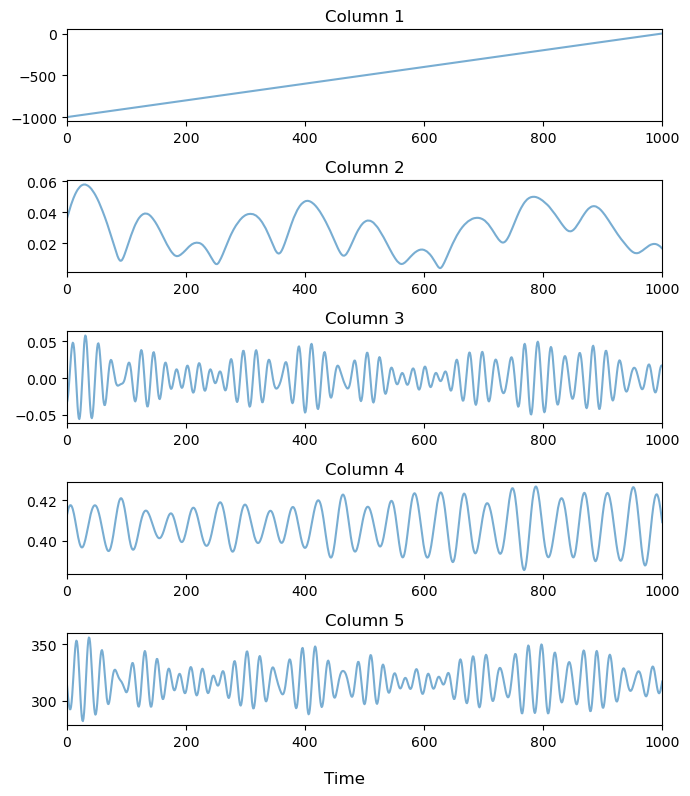

(5, 1001)
Column 1 min:  -1000.0 / max:  0.0
Column 2 min:  0.004155 / max:  0.057815
Column 3 min:  -0.05573 / max:  0.05768
Column 4 min:  0.385302 / max:  0.426813
Column 5 min:  282.261295 / max:  355.966432


In [6]:
dat = np.loadtxt('milankovitch_data.dat')
print(dat.shape)

# Checking the data structure
t  = np.arange(1001)
y = dat.T
fig, axs = plt.subplots(5, 1, figsize=(7, 8), sharex=False)
for i in range(5):
    axs[i].plot(t,  y[i], alpha=0.6)
    axs[i].set(xlim = [0,1000])
    axs[i].set_title(f"Column {i+1}")
fig.supxlabel("Time", fontsize=12) #xlabel for entire graphs
plt.tight_layout()
plt.show()

print(y.shape)
for i in range(5):
    print(f"Column {i+1} min: ", np.min(y[i]), "/ max: ", np.max(y[i]))


#### Variables Description on the website (IMCCE)

The result window contains two or more columns :

1. time (expressed in 103 Julian years since J2000.0, the julian year is equal to 365.25 days
2. eccentricity (if checked)
3. climatic precession (if checked)
4. obliquity (if checked, expressed in radians)
5. insolation quantities (if checked, expressed in W/m2)

#### Assign the columns to variables
1. Column 1 : Time (kyr)
2. Column 2 : Eccentricity
3. Column 3 : Obliquity (degrees)
4. Column 4 : Climate precession (radians)
5. Column 5 : Insolation (W/m2)

In [7]:
time = y[0]
ecc = y[1]
obl = y[2]
pre = y[3]
iso = y[4]

### 2
Normalize the insolation time series such that it has zero mean and unit standard deviation (“z-score”) and create a phase-space reconstruction from both the normalized and the original insolation time series using embedding dimension m = 4 and embedding delay τ = 5. (5P)

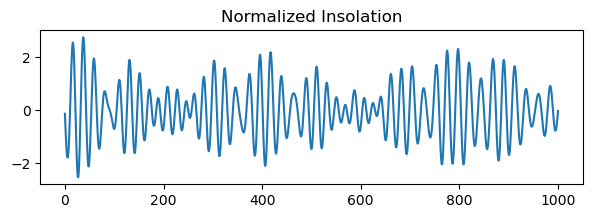

(1001,)


In [8]:
# Normalize the insolation time series
z = (iso - np.mean(iso)) / np.std(iso)
fig, ax = plt.subplots(figsize = (7, 2)) # figsize is adjusting your whole picture size
ax.plot(t, z)
ax.set_title("Normalized Insolation")
plt.show()

print(z.shape)


In [9]:
def embed(x: np.ndarray, m: int, tau: int) -> np.ndarray:
    """Embeds a scalar time series in m dimensions with time delay tau.

    Parameters
    ----------
    x : np.ndarray
        The scalar time series
    m : int
        Embedding dimmension
    tau : int
        Time delay

    Returns
    -------
    np.ndarray
        The embedded mutli dimensional time series.
    """
    
    n = len(x)
    k = n - (m - 1) * tau
    z = np.zeros((k, m), dtype="float")
    for i in range(k):
        z[i] = [x[i + j * tau] for j in range(m)]

    return np.stack(z)

In [10]:
# Phase-space Reconstruction 

# Embedding
emb_origin = embed(iso, m = 4, tau = 5)
emb_norm = embed(z, m = 4, tau = 5)


### 3
Compute the recurrence plot from the normalized insolation time series with a recurrence threshold of ε = 1 and from the original time series with ε = 6. Explain the changes you observe. (6P)

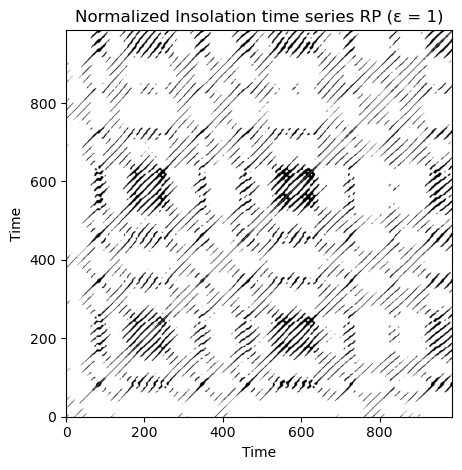

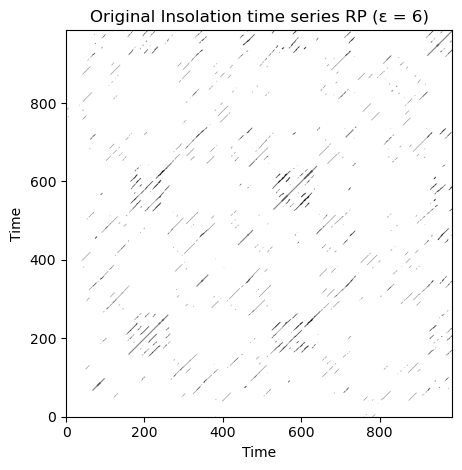

In [12]:
def rpplot(timeseries_name, timeseries, epsilon):
    distance = np.linalg.norm(timeseries[:, None] - timeseries[None, :], axis=2) # recurrence matrix
    R = (distance < epsilon).astype(int) 
    diag = np.diag_indices_from(R) # remove diagonal for avoiding calculate the distance with itself
    R[diag] = 0

    plt.imshow(R, cmap='binary', origin='lower')
    plt.title(f"{timeseries_name} Insolation time series RP (ε = {epsilon})")
    plt.ylabel("Time")
    plt.xlabel("Time")
    plt.tight_layout()
    plt.show()
    return distance

dis1 = rpplot("Normalized", emb_norm, 1)
dis2 = rpplot("Original", emb_origin, 6)

In normalised insolation, the time series data range -3 to 3, so in this time series, epsilon 1 is comparatively big value. It means there are lot of points are included in the recurrence spot. 

In original insolation, epsilon value 6 is bigger than the value which I used for plotting the normalised insolation, but original insolation data range 300 to 350, it means epsilon value 6 is comparatively small value. So the RP shows low density compared to the normalised RP.

### 4
Discuss how a suitable recurrence threshold could be selected and find an adaptive method that yields matching recurrence plots for both series. (6P)

If recurrence threshold (epsilon) is too small, RP plots no points, no essential structures shows. However, if recurrence threshold is too large, RP shows the merged structures, thick lines, completely full. Optimal selection is showing large variety of structures, thin
lines, different time scales visible. 

For selecting suitable threshold, we can use 'Quantile Approach'
- Preselect RR : RR(ε) → ε
- Quantile of distance distribution : p(x < Di,j)
  - e.g., ε = D0.1, (for RR = 0.1) i.e.,0.1 = p(ε < Di,j)
- Quantile = recurrence rate


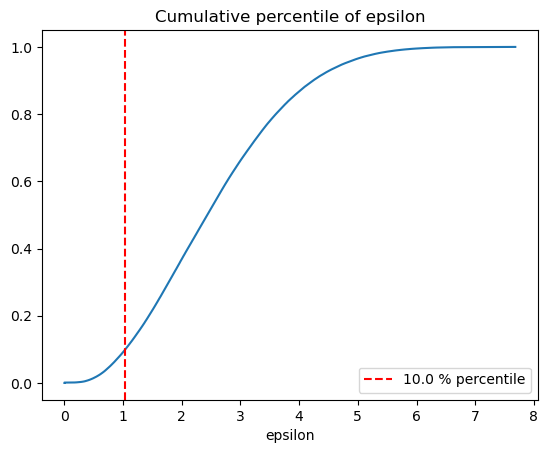

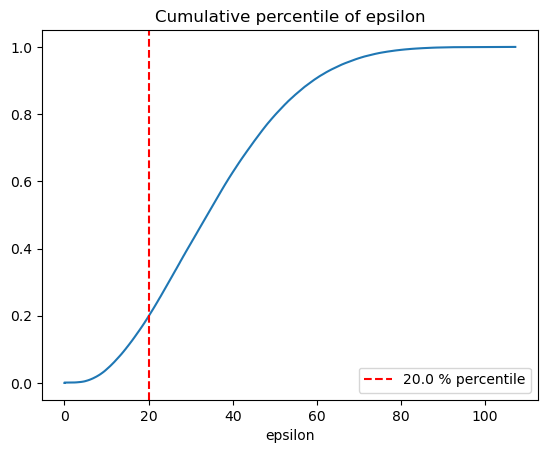

optimized epsilon for Normalized Insolation : 1.0384391088752913
optimized epsilon for Original Insolation : 20.096874925393635


In [15]:
# Cumulative Probability

def find_opt_eps(distance, percentage):
    od = np.sort(np.ravel(distance))
    eps_opt = np.quantile(od, percentage)
    N = len(od)
    cum_prob = np.arange(N) / (N - 1)
    plt.plot(od, cum_prob)
    plt.title("Cumulative percentile of epsilon")
    plt.axvline(x = eps_opt, color = 'red', linestyle = '--', label = f'{percentage * 100} % percentile')
    plt.xlabel("epsilon")
    plt.legend()
    plt.show()
    return eps_opt

eps_opt_normalised = find_opt_eps(dis1, 0.1) # optimized epsilon as 10% percentile value for normalized time series
eps_opt_original = find_opt_eps(dis2, 0.2) # optimized epsilon as 20% percentile value for original time series

print("optimized epsilon for Normalized Insolation :",eps_opt_normalised)
print("optimized epsilon for Original Insolation :",eps_opt_original)

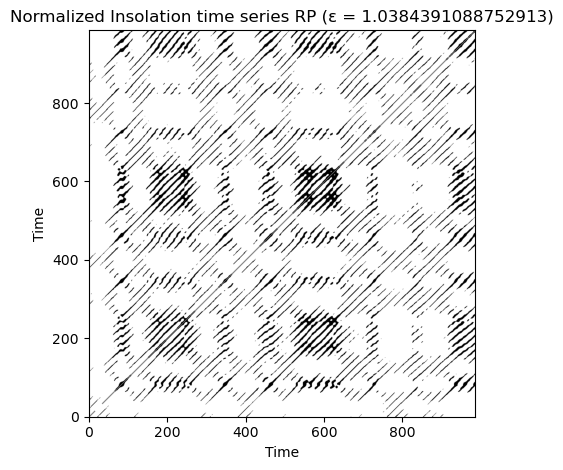

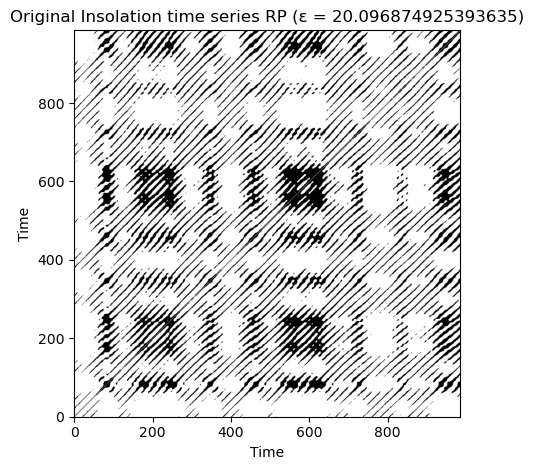

In [18]:
# Replot the RP for optimized epsilon

dis1 = rpplot("Normalized", emb_norm, epsilon = eps_opt_normalised)
dis2 = rpplot("Original", emb_origin, epsilon = eps_opt_original)